# Data Exploration

**Description**: https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

**Goal**: Predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc. The data comes from renthop.com, an apartment listing website. These apartments are located in New York City.

**Target variable**: interest_level, it is defined by the number of inquiries a listing has in the duration that the listing was live on the site.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)    # #columns to display
#pd.set_option('display.max_colwidth', -1) # show all the text strings in the column

#color = sns.color_palette()
#sns.palplot(sns.color_palette('colorblind'))
sns.set_palette('dark')

%matplotlib inline

In [3]:
train_df = pd.read_json('train.json').reset_index(drop=True)
test_df = pd.read_json('test.json').reset_index(drop=True)

In [4]:
train_df.shape, test_df.shape

((49352, 15), (74659, 14))

In [5]:
train_df['test'] = False
test_df['test'] = True

df = train_df.append(test_df).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124011 entries, 0 to 124010
Data columns (total 16 columns):
bathrooms          124011 non-null float64
bedrooms           124011 non-null int64
building_id        124011 non-null object
created            124011 non-null object
description        124011 non-null object
display_address    124011 non-null object
features           124011 non-null object
interest_level     49352 non-null object
latitude           124011 non-null float64
listing_id         124011 non-null int64
longitude          124011 non-null float64
manager_id         124011 non-null object
photos             124011 non-null object
price              124011 non-null int64
street_address     124011 non-null object
test               124011 non-null bool
dtypes: bool(1), float64(3), int64(3), object(9)
memory usage: 14.3+ MB


In [6]:
df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,test
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,False
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,False
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,False


In [7]:
pd.options.display.float_format = '{:,.0f}'.format
#pd.set_option('display.precision', 2)
df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,"124,011","124,011","124,011","124,011","124,011","124,011"
mean,1,2,41,"7,024,022",-74,"3,781"
std,1,1,1,"126,380",1,"15,830"
min,0,0,0,"6,811,957",-121,1
25%,1,1,41,"6,915,638",-74,"2,495"
50%,1,1,41,"7,021,451",-74,"3,150"
75%,1,2,41,"7,129,028",-74,"4,100"
max,112,8,45,"7,761,779",0,"4,490,000"


In [8]:
df[(df.bathrooms==112) | (df.price == 1) | (df.price==4490000)]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,test
19558,1,2,cd25bbea2af848ebe9821da820b725da,2016-06-24 05:02:11,,Hudson Street,"[Doorman, Elevator, Cats Allowed, Dogs Allowed...",low,41,7208764,-74,d1737922fe92ccb0dc37ba85589e6415,[],4490000,421 Hudson Street,False
69023,112,3,33fa7be8ea2ffc6353af117cab78f569,2016-06-07 05:22:55,"This is a pretty, charming, prime location 3 b...",East 75th Street,[Hardwood Floors],NaN,41,7120577,-74,3e1edc05ca35eaecc90766629d22d078,[https://photos.renthop.com/2/7120577_dea70af4...,3700,433 East 75th Street,True
87120,1,2,0,2016-05-23 18:06:47,Stay in control of your rental\rSeal is the be...,140 West Street,[http://sealagreements.com/leasing/],NaN,41,7056147,-74,b8db1eaabe00c9cc383a146a4748feb6,[https://photos.renthop.com/2/7056147_0594c887...,1,140 West Street,True


In [9]:
df.isnull().sum(axis = 0) # no missing values in train dataset

bathrooms              0
bedrooms               0
building_id            0
created                0
description            0
display_address        0
features               0
interest_level     74659
latitude               0
listing_id             0
longitude              0
manager_id             0
photos                 0
price                  0
street_address         0
test                   0
dtype: int64

In [10]:
print 'Min: ', df.created.min()
print 'Max: ', df.created.max()

Min:  2016-04-01 22:12:41
Max:  2016-06-29 21:55:35


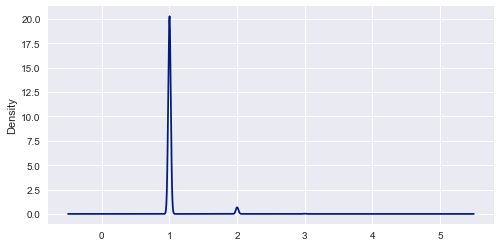

In [11]:
df['created'] = pd.to_datetime(df.created)
df.created.value_counts().sort_index().plot(kind='density', figsize=(8,4))

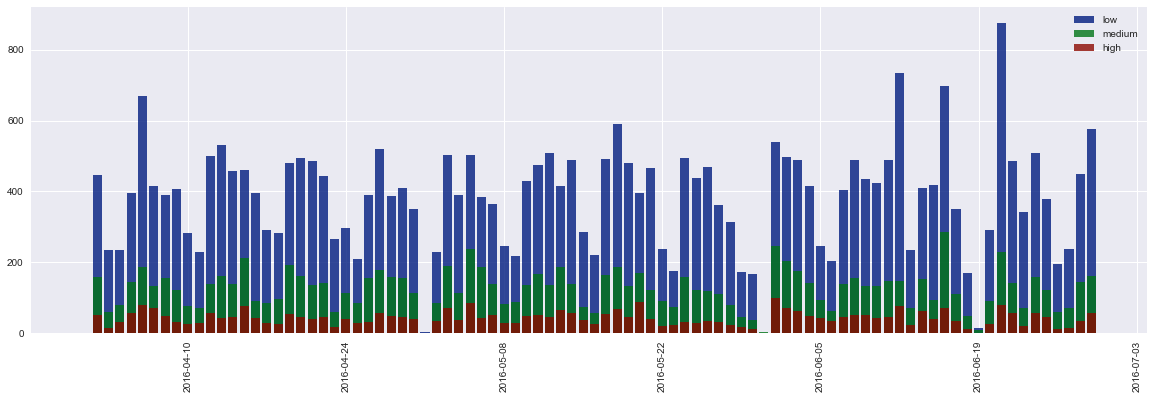

In [12]:
plt.figure(figsize=(20, 6))

high = df[df.interest_level=='high'].created.dt.date.value_counts()
medium = df[df.interest_level=='medium'].created.dt.date.value_counts()
low = df[df.interest_level=='low'].created.dt.date.value_counts()

p1 = plt.bar(low.index, low.values, alpha=0.8)
p2 = plt.bar(medium.index, medium.values, alpha=0.8)
p3 = plt.bar(high.index, high.values, alpha=0.8)

plt.legend((p1[0], p2[0], p3[0]), ('low', 'medium', 'high'))

plt.xticks(rotation='vertical')
plt.show()

## Numeric variables

### Bathrooms and Bedrooms

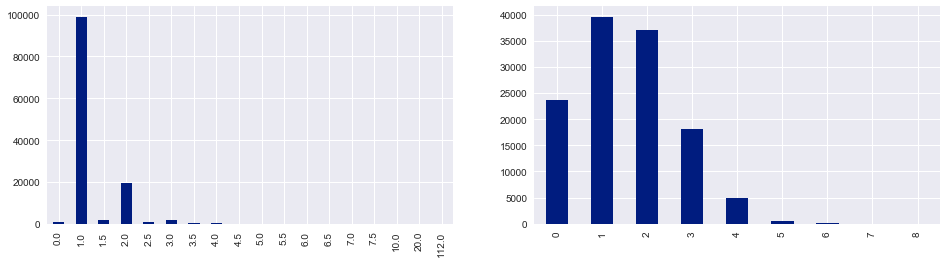

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

df.bathrooms.value_counts().sort_index().plot(kind='bar', ax=axes[0])
df.bedrooms.value_counts().sort_index().plot(kind='bar', ax=axes[1])

We may use a treshold for #bedrooms/bathrooms to remove the outliners.

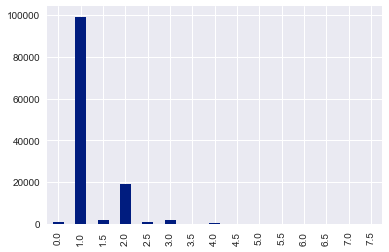

In [14]:
df.bathrooms.where(df.bathrooms < 10).value_counts().sort_index().plot(kind='bar')

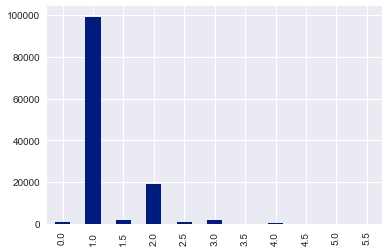

In [15]:
#df.loc[df.bathrooms >= 6] = 0
df.bathrooms = df.bathrooms.map(lambda b: b if b < 6 else 0)
df.bathrooms.value_counts().sort_index().plot(kind='bar')

### Latitude and Longitude

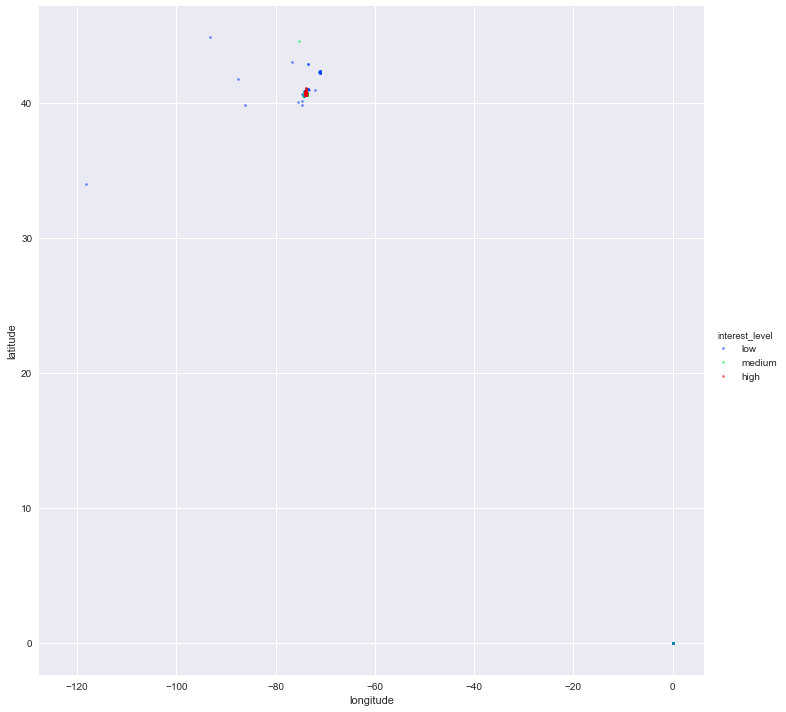

In [16]:
sns.lmplot(x='longitude', y='latitude', data=df, hue='interest_level', fit_reg=False, 
           scatter_kws={'alpha':0.6, 's':7}, size=10, hue_order=[u'low', u'medium', u'high'], palette='bright')

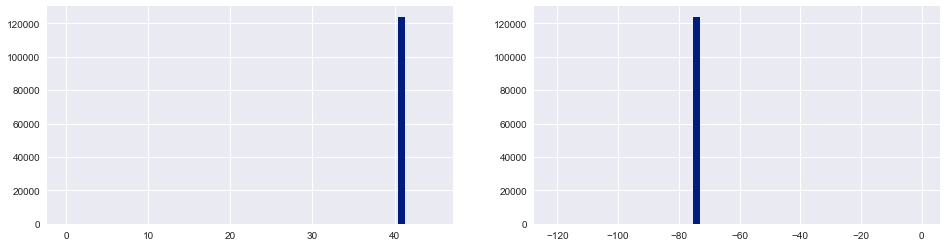

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

df.latitude.hist(bins = 50, ax=axes[0])
df.longitude.hist(bins = 50, ax=axes[1])

There are some outliners. Let's move them to the center.

In [18]:
(lat_min, lat_max), lat_mean = np.percentile(df.latitude, [1, 99]).tolist(), np.mean(df.latitude)
(lon_min, lon_max), lon_mean = np.percentile(df.longitude, [1, 99]).tolist(), np.mean(df.longitude)
print "For latitude min/max/mean: %s, %s, %s " % (lat_min, lat_max, lat_mean)
print "For longitude min/max/mean: %s, %s, %s " % (lon_min, lon_max, lon_mean)

df.latitude = np.where(df.latitude < lat_min, lat_mean, df.latitude)
df.longitude = np.where(df.latitude < lat_min, lon_mean, df.longitude)

df.latitude = np.where(df.latitude > lat_max, lat_mean, df.latitude)
df.longitude = np.where(df.latitude > lat_max, lon_mean, df.longitude)

df.latitude = np.where(df.longitude < lon_min, lat_mean, df.latitude)
df.longitude = np.where(df.longitude < lon_min, lon_mean, df.longitude)

df.latitude = np.where(df.longitude > lon_max, lat_mean, df.latitude)
df.longitude = np.where(df.longitude > lon_max, lon_mean, df.longitude)

For latitude min/max/mean: 40.63981, 40.8614, 40.7376406811 
For longitude min/max/mean: -74.0162, -73.8507, -73.9494341187 


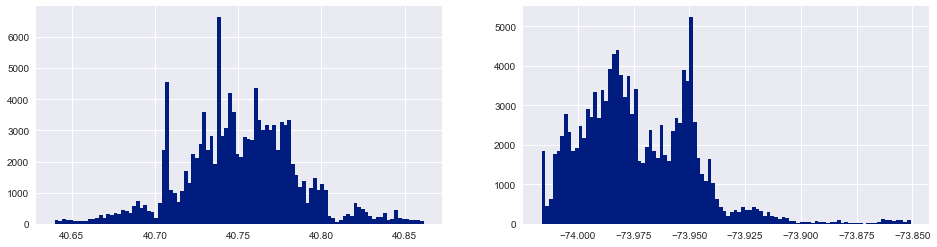

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

df.latitude.hist(bins = 100, ax=axes[0])
df.longitude.hist(bins = 100, ax=axes[1])

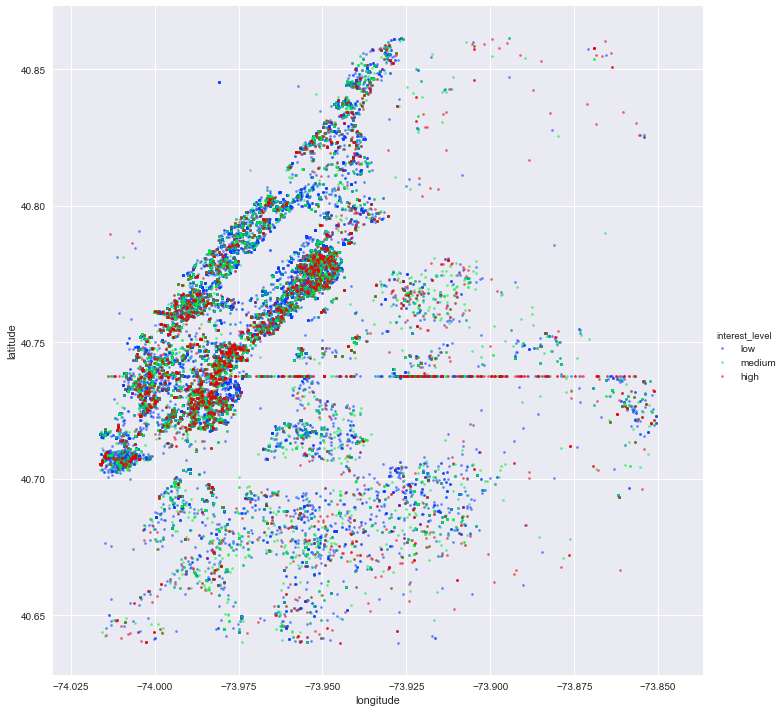

In [20]:
sns.lmplot(x='longitude', y='latitude', data=df, hue='interest_level', fit_reg=False, 
           scatter_kws={'alpha':0.6, 's':7}, size=10, hue_order=[u'low', u'medium', u'high'], palette='bright')

### Price

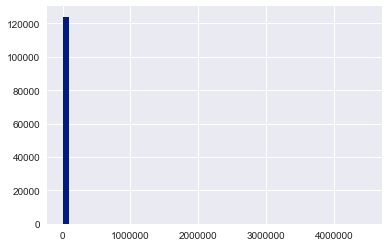

In [21]:
df.price.hist(bins = 50)

In case of removing the left tail, we will remove the group of listings for people who are looking for a roommate, so let's cut off only the right one.

Threshold:  13000.0


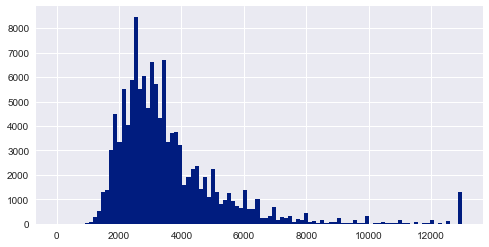

In [22]:
price_max = np.percentile(df.price, 99).tolist()
print "Threshold: ", price_max

df.price = np.where(df.price > price_max, price_max, df.price)

df.price.hist(bins = 100, figsize=(8,4))

As an another option we could try to use logarithm of the price as a new feature.

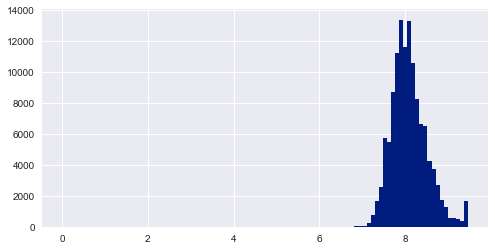

In [23]:
df['price_log'] = np.log(df.price.where(df.price>0))

df.price_log.hist(bins = 100, figsize=(8,4))

### Target variable and its correlation within the others

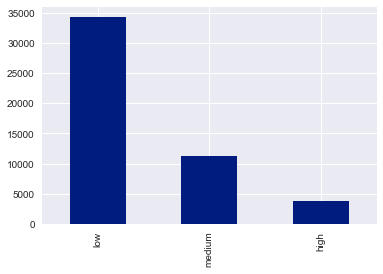

In [24]:
train_df.interest_level.value_counts().plot(kind='bar')

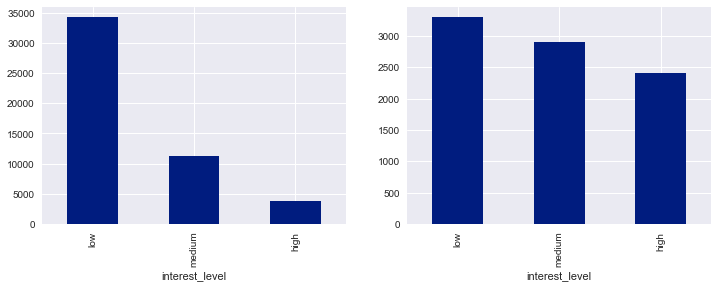

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

train_df.groupby('interest_level').price.count().reindex([u'low', u'medium', u'high']).plot(kind='bar', ax=axes[0])
train_df.groupby('interest_level').price.median().reindex([u'low', u'medium', u'high']).plot(kind='bar', ax=axes[1])

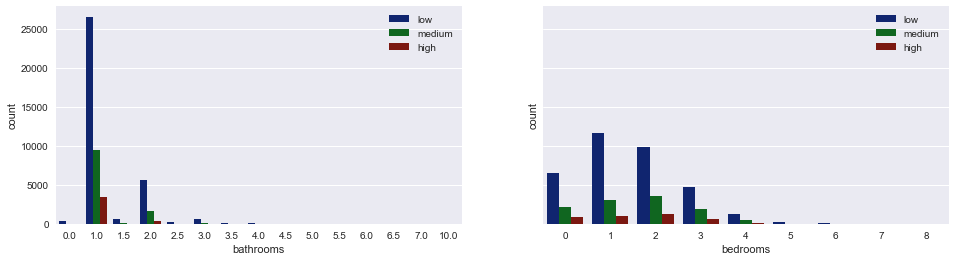

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sns.countplot(x='bathrooms', hue='interest_level', data=train_df, hue_order=[u'low', u'medium', u'high'], ax=ax1).legend(loc=1).figure.set_size_inches(16,4)
sns.countplot(x='bedrooms', hue='interest_level', data=train_df, hue_order=[u'low', u'medium', u'high'], ax=ax2).legend(loc=1).figure.set_size_inches(16,4)

In [27]:
df.building_id.value_counts().head(10)

0                                   20664
96274288c84ddd7d5c5d8e425ee75027      705
11e1dec9d14b1a9e528386a2504b3afc      546
bb8658a3e432fb62a440615333376345      522
80a120d6bc3aba97f40fee8c2204524b      510
ce6d18bf3238e668b2bf23f4110b7b67      459
f68bf347f99df026f4faad43cc604048      457
c94301249b8c09429d329864d58e5b82      410
ea9045106c4e1fe52853b6af941f1c69      397
128d4af0683efc5e1eded8dc8044d5e3      385
Name: building_id, dtype: int64

In [28]:
train_df.building_id.value_counts().head(10)

0                                   8286
96274288c84ddd7d5c5d8e425ee75027     275
11e1dec9d14b1a9e528386a2504b3afc     215
80a120d6bc3aba97f40fee8c2204524b     213
bb8658a3e432fb62a440615333376345     212
f68bf347f99df026f4faad43cc604048     191
c94301249b8c09429d329864d58e5b82     167
ce6d18bf3238e668b2bf23f4110b7b67     165
57ef86c28a8ae482dc3a3c3af28e8e48     159
128d4af0683efc5e1eded8dc8044d5e3     153
Name: building_id, dtype: int64

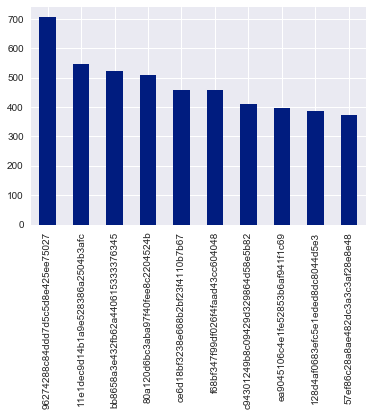

In [29]:
df.building_id.where(df.building_id != '0').value_counts().head(10).plot(kind='bar')

In [30]:
bldg_id_counts = df.building_id.value_counts()
df['listings_in_bldg'] = df.building_id.map(lambda b: bldg_id_counts[b] if b != '0' else 1)

In [31]:
df.loc[df.interest_level == 'low', 'listings_in_bldg'] = 0
df.loc[df.interest_level == 'medium', 'listings_in_bldg'] = 0

In [32]:
df[['interest_level', 'listings_in_bldg']].head(10)

,interest_level,listings_in_bldg
0,medium,0
1,low,0
2,high,131
3,low,0
4,low,0
5,medium,0
6,low,0
7,low,0
8,medium,0
9,low,0


In [33]:
df.manager_id.value_counts().head(10)

e6472c7237327dd3903b3d6f6a94515a    6387
6e5c10246156ae5bdcd9b487ca99d96a    1683
8f5a9c893f6d602f4953fcc0b8e6e9b4    1011
cb87dadbca78fad02b388dc9e8f25a5b     971
62b685cc0d876c3a1a51d63a0d6a8082     956
9df32cb8dda19d3222d66e69e258616b     862
2aa9bfa5f67ed9997ea341dee8a3a271     853
b7de4cb395920136663132057fa89d84     849
ad3d8ddc52c7e0859b5c6c7f7949c3bd     732
c9c33695ee2a2f818e9f1d8f7d1c4b39     731
Name: manager_id, dtype: int64

In [34]:
df.manager_id.value_counts().tail(10)

947ae5d7d68d4e3dd500e60563065da7    1
799d6cf108cb6350e10eb2a4d77dc075    1
6e7b18d0e13c7d8ab2f25f19fc206f15    1
b3a3aae7392093169b83436f8491adc0    1
84a791745d2377d963f05ebf45bee94b    1
28f2ee59507afb3229af1cd81b9d1f08    1
0ead4ce211989abed5452c6d12cee62e    1
2e275003f2c453844267e2b8bf794f90    1
ab01d605707d7910288be73b9756d3aa    1
644412373f48247dbe136cedce607aab    1
Name: manager_id, dtype: int64

In [35]:
sf = df.manager_id.value_counts()
managers_df = pd.DataFrame({'manager_id':sf.index, 'cnt':sf.values})
managers_df.where(managers_df.cnt == 1).sum()

cnt   1,060
dtype: float64

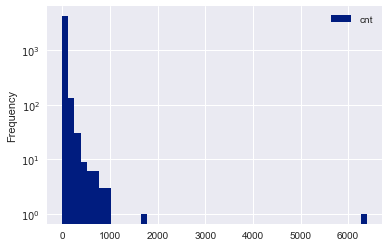

In [36]:
managers_df.plot(kind='hist', bins=50, log=True)

In [37]:
manager_id_counts = df.manager_id.value_counts()
df['listings_per_manager'] = df.manager_id.map(lambda b: manager_id_counts[b] if b != '0' else 1)

In [38]:
df.loc[df.interest_level == 'low', 'listings_per_manager'] = 0
df.loc[df.interest_level == 'medium', 'listings_per_manager'] = 0

In [39]:
df[['interest_level', 'listings_per_manager']].head(10)

,interest_level,listings_per_manager
0,medium,0
1,low,0
2,high,314
3,low,0
4,low,0
5,medium,0
6,low,0
7,low,0
8,medium,0
9,low,0


In [40]:
df['num_photos'] = df.photos.apply(len)
df['num_features'] = df.features.apply(len)
df['description_size'] = df.description.apply(lambda x: len(x.split(" ")))

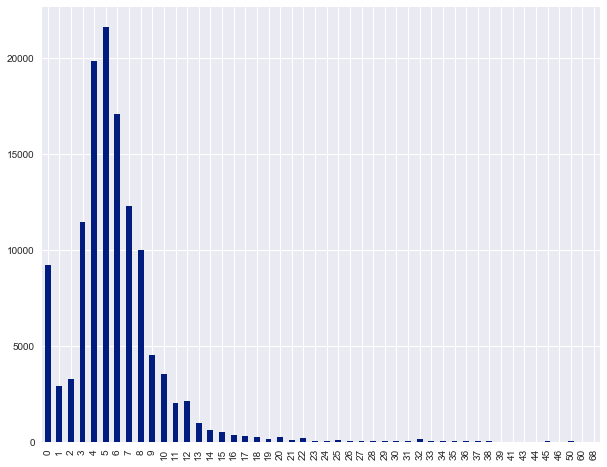

In [41]:
df.num_photos.value_counts().sort_index().plot(kind='bar', figsize=(10,8))

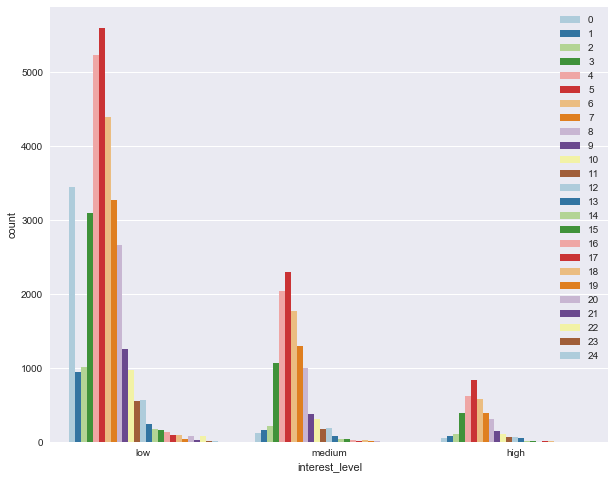

In [42]:
sns.countplot(x='interest_level', hue='num_photos', data=df[df.num_photos<25], order=[u'low', u'medium', u'high'], palette='Paired').legend(loc=1).figure.set_size_inches(10,8)

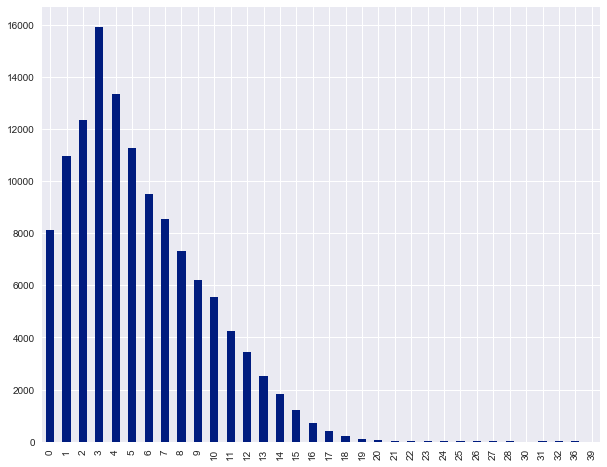

In [43]:
df.num_features.value_counts().sort_index().plot(kind='bar', figsize=(10,8))

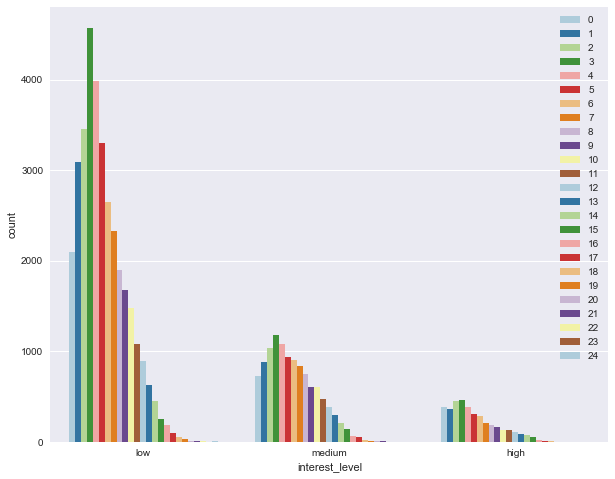

In [44]:
sns.countplot(x='interest_level', hue='num_features', data=df[df.num_features<25], order=[u'low', u'medium', u'high'], palette='Paired').legend(loc=1).figure.set_size_inches(10,8)

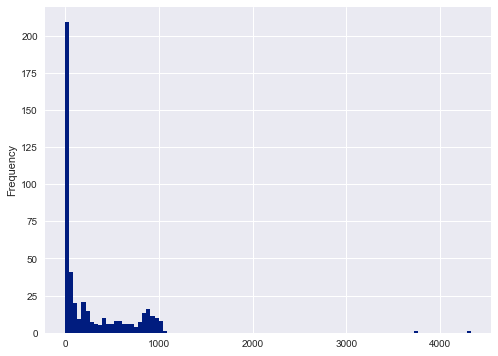

In [45]:
df.description_size.value_counts().sort_index().plot(kind='hist', bins=100, figsize=(8,6))

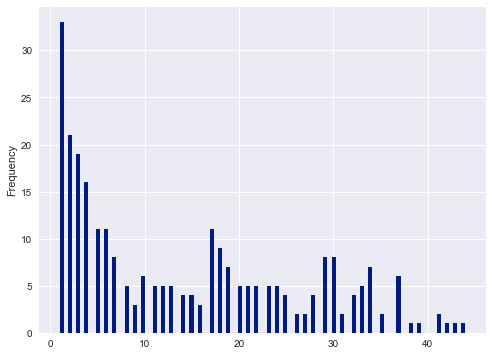

In [46]:
df[df.interest_level=='high'].description_size.value_counts().sort_index().plot(kind='hist', bins=100, figsize=(8,6))

In [47]:
df['month'] = df.created.dt.strftime('%b')
df['hod'] = df.created.dt.hour
df['dow'] = df.created.dt.strftime('%A')

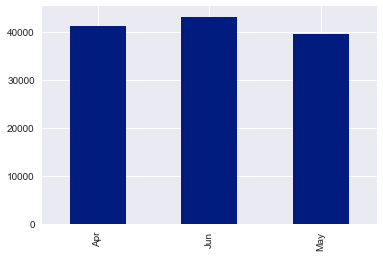

In [48]:
df.month.value_counts().sort_index().plot(kind='bar')

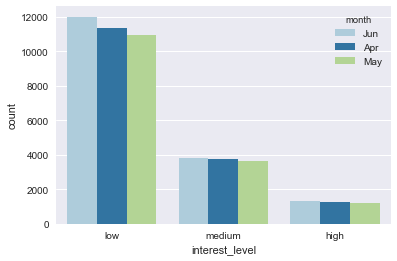

In [49]:
sns.countplot(x='interest_level', hue='month', data=df, order=[u'low', u'medium', u'high'], palette='Paired')

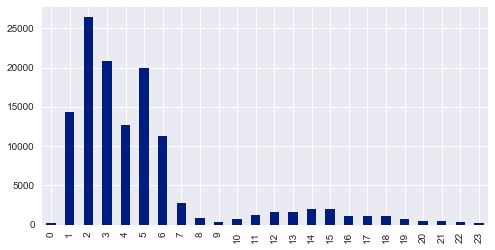

In [50]:
df.hod.value_counts().sort_index().plot(kind='bar', figsize=(8,4))

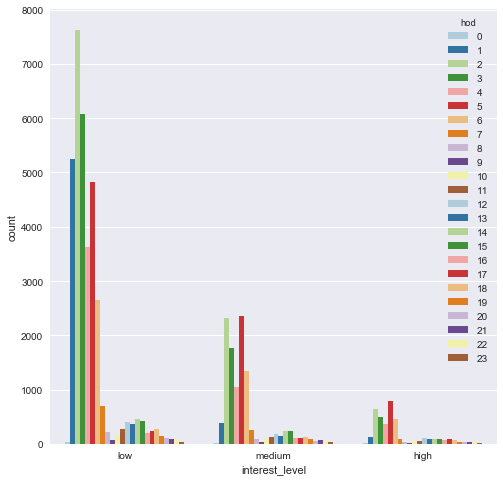

In [51]:
sns.countplot(x='interest_level', hue='hod', data=df, order=[u'low', u'medium', u'high'], palette='Paired').figure.set_size_inches(8,8)

In [52]:
df['hod_shifted'] = df.created.dt.tz_localize('utc').dt.tz_convert('US/Pacific').dt.hour

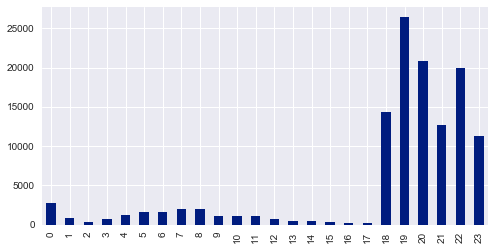

In [53]:
df.hod_shifted.value_counts().sort_index().plot(kind='bar', figsize=(8,4))

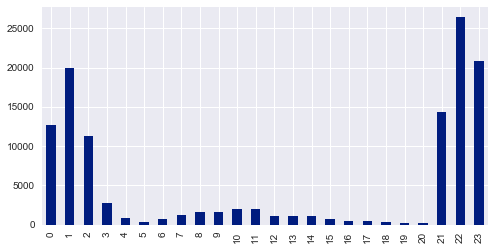

In [54]:
df['hod_shifted_est'] = df.created.dt.tz_localize('utc').dt.tz_convert('US/Eastern').dt.hour
df.hod_shifted_est.value_counts().sort_index().plot(kind='bar', figsize=(8,4))

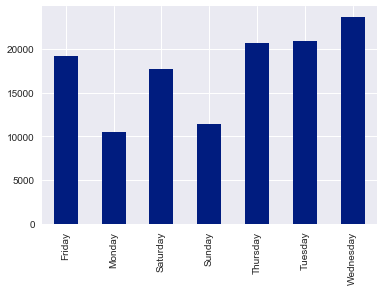

In [55]:
df.dow.value_counts().sort_index().plot(kind='bar')

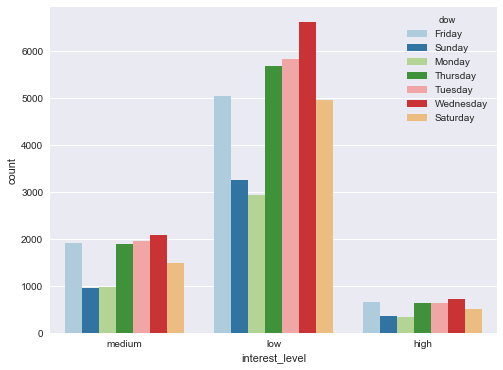

In [56]:
sns.countplot(x='interest_level', hue='dow', data=df, palette='Paired').figure.set_size_inches(8,6)

/Users/ikononenko/tensorflow/lib/python2.7/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/Users/ikononenko/tensorflow/lib/python2.7/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


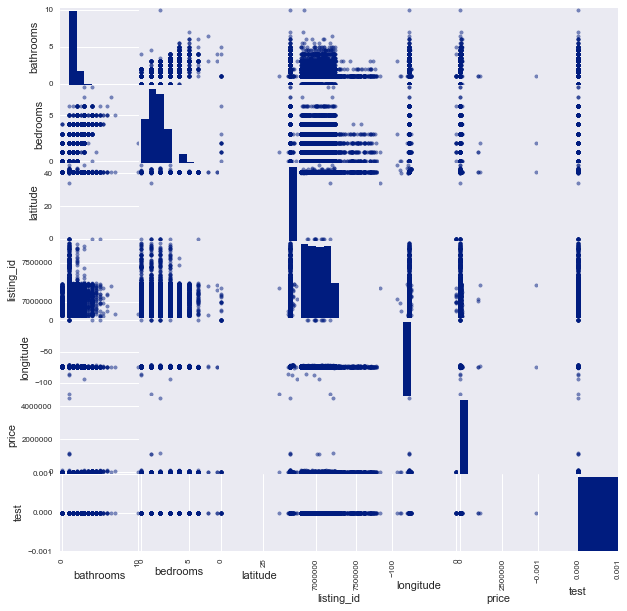

In [57]:
# Scatter Matrix
pd.scatter_matrix(train_df, figsize=(10, 10))
plt.show()

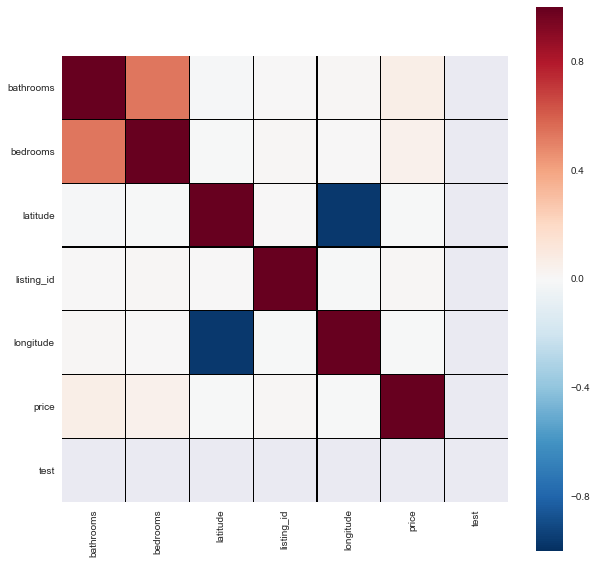

In [58]:
# Pearson Correlation Matrix
sns.heatmap(train_df.corr(), linewidths=0.25, vmax=1.0, square=True , linecolor='black').figure.set_size_inches(10,10)